# Objective:

The objective of this notebook is to forecasting the quantity of cakes sold in the cafe. We will use the data we cleaned in the previous notebook using Prophet.

---

# Import libraries

First, we need to import the necessary libraries, and check our plotly version.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
import statsmodels.api as sm
import pymysql
import matplotlib
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import math
import itertools
import seaborn as sns
import random 
from statsmodels.api import tsa
import warnings
warnings.filterwarnings("ignore")
plotly.__version__

'4.12.0'

---

# View the data

In [5]:
cakes = pd.read_csv('data\cakes_weekly.csv')
cakes

,ds,y
0,2017-01-02,16.0
1,2017-01-30,9.0
2,2017-02-27,6.0
3,2017-04-03,4.0
4,2017-05-01,6.0
...,...,...
155,2020-11-02,17.0
156,2020-11-09,11.0
157,2020-11-16,17.0
158,2020-11-23,16.0


# Instantiate the model

In [7]:
model = Prophet(interval_width=0.95, changepoint_prior_scale=1.0)
model

#### After some experimentation, I set the `changepoint_prior_scale` to `1.0`. Increases in this parameter allows the forecasted trend to be more flexible. This means that the model becomes more responsive to new data.

#### I also set the `interval_width` to `0.95` so that most of the actual data points fit within the uncertainty interval. This number is on the higher end which is alright for this problem. According to an executive from the company, cakes can last between 3-4 months if they are kept frozen.

# Splitting the data into train and test sets

We need to separate the data into train data with which the model uses to learn the trend, and test data which the model does not see. We use the test data to see if the model can predict the future based on only data it has seen.

Since I only have 160 data points, I will split the data in half. Ideally, if I had more I would increase the test size to make a 30-70 split

In [8]:
test_size = 80
train_size = cakes.shape[0]-test_size
test = cakes.iloc[-test_size:]
train = cakes.iloc[:-test_size]

print(test.shape)
print(train.shape)

(80, 2)
(80, 2)


# Fitting the model
Now, we can fit the model to the train data.

In [10]:
model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Create future dates
 We need to generate the dates that the model will predict.

In [11]:
future_dates = model.make_future_dataframe(periods=test.shape[0], freq='W', include_history=True)

In [12]:
future_dates.shape

(160, 1)

In [13]:
future_dates.head()

,ds
0,2017-01-02
1,2017-01-30
2,2017-02-27
3,2017-04-03
4,2017-05-01


In [14]:
future_dates.tail()

,ds
155,2020-09-06
156,2020-09-13
157,2020-09-20
158,2020-09-27
159,2020-10-04


# Forecast sales quantity

Now that we have our x (Dates), we can let the model predict our y: How many slices of cake will we sell?

In [16]:
prediction = model.predict(future_dates)

In [17]:
prediction.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
155,2020-09-06,9.214175,-35.912364,28.923103,-17.355462,35.025257,-11.214894,-11.214894,-11.214894,-11.214894,-11.214894,-11.214894,0.0,0.0,0.0,-2.000719
156,2020-09-13,8.905638,-37.369827,25.153428,-18.175835,35.105050,-14.699057,-14.699057,-14.699057,-14.699057,-14.699057,-14.699057,0.0,0.0,0.0,-5.793419
157,2020-09-20,8.597102,-37.562820,27.381058,-18.996097,35.282524,-13.093751,-13.093751,-13.093751,-13.093751,-13.093751,-13.093751,0.0,0.0,0.0,-4.496649
158,2020-09-27,8.288566,-35.122909,34.192907,-19.813677,35.495748,-7.895955,-7.895955,-7.895955,-7.895955,-7.895955,-7.895955,0.0,0.0,0.0,0.392611
159,2020-10-04,7.980030,-28.919253,37.358024,-20.526995,35.784421,-3.978874,-3.978874,-3.978874,-3.978874,-3.978874,-3.978874,0.0,0.0,0.0,4.001156


## Interpreting the forecast

The number of cake slices the model predicts will be sold is located in the feature, `yhat`, with uncertainty interval bounds in the features `yhat_upper` and `yhat_lower`.

Keep in mind: Some of our features have negative values. It is not possible to have negative sales in this context! This is evidence that Prophet does not see the context of the data, so we need to keep that in mind.

### Let's plot it!

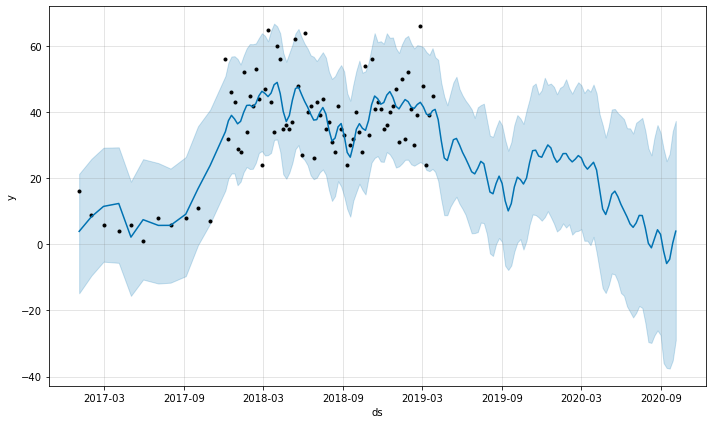

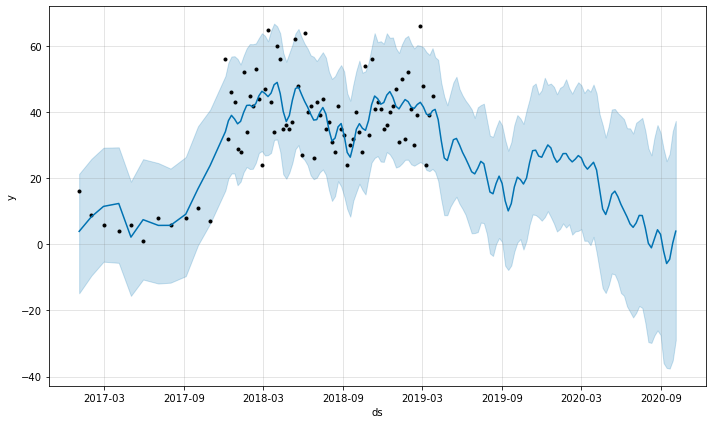

In [18]:
model.plot(prediction)

#### The black points above are the actual sales. The width of the shaded blue are is dictated by changepoint_prior_scale. We can see above that there is a downward trend, even prior to the pandemic.

### Business Implications:

When ordering raw materials, I recommend executives to order within the shaded area given the financial constraint the cafe is facing, and the pandemic. There is some wiggle room here, but more contextual factors need to be taken into account when determining whether to stay on the line, or slightly below or above it.

## Below, we can see the yearly seasonality.

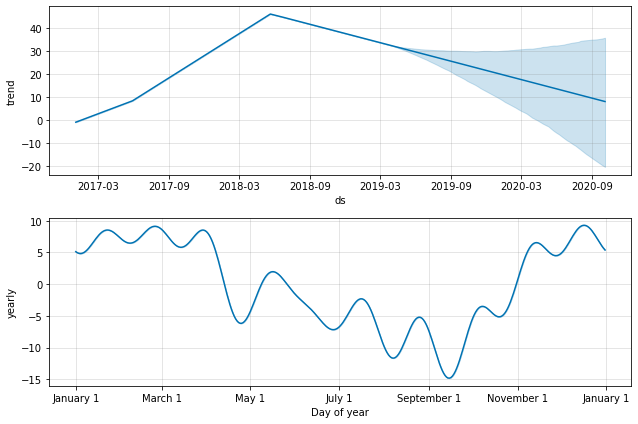

In [19]:
model.plot_components(prediction);

---

# Model Evaluation

We must evaluate the model to see how effective it is using sklearn. For ease of interpretability for the executives of the company, I will focus on mean_absolute_error 

In [27]:
# import several metrics
from sklearn.metrics import r2_score, mean_absolute_error

In [28]:
r2_score(cakes.y, prediction.yhat)

0.08314519741001547

### This is a low r2 value. It means that the model only explains 5% of variance

In [31]:
mean_absolute_error(cakes.y, prediction.yhat)

12.931652649584564

In [32]:
print(f'On average, the forecast differs from actual values by: {round(mean_absolute_error(cakes.y, prediction.yhat))} slices of cake')

On average, the forecast differs from actual values by: 13 slices of cake


#### On average, the forecast is approximately 1 cake off (1cake = 12 slices).

### We can also look at the mean percentage error...

However, this is not particularly useful given the small scale operation of the business. If the forecast predicts that the cafe sells 1 slice of cake in a week, but the cafe actually sells 3, the forecast is 300% off. This metric could make the results seem worse than they actually are.

In [35]:
mean_absolute_percentage_error = 100*mean_absolute_error(cakes.y, prediction.yhat)/cakes.y
mean_absolute_percentage_error

0       80.822829
1      143.685029
2      215.527544
3      323.291316
4      215.527544
          ...    
155     76.068545
156    117.560479
157     76.068545
158     80.822829
159    184.737895
Name: y, Length: 160, dtype: float64

---

Unfortunately, because I took too long in Data cleaning and delays in acquiring the data, I did not have sufficient time to complete the following stages before the deadline for this project: 

1. Hyperparameter tuning
2. Cross validation
3. Trying out more models

If you would like to see my attempts to complete the stages above, please see the next notebook: 


`4. Unfinished Code for Future Competion`
